<a href="https://colab.research.google.com/github/2ovisa/AH2179/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stop ahead prediction
- intressant för resenärer att veta hur stor förseningen blir vid sitt stop
- intressant för resenärer att veta hur stor förseningen är vid sin påstigande station

##Data Preparation

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

#-------------------------------------------------data preprocessing------------------------------------------------------------------

url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/ProjectAssignmentData/Dataset-PT.csv'
df = pd.read_csv(url, header = 1)
#print(df.head(1))
#df.info()
#print(df.columns.tolist())

#df = df.iloc[:1000]



###Kolumner att droppa:
- Identifiers: Calender_date, route_id, bus_id (innehåller inte nödvändig information
- They who leak future knowledge: Arrival_delay (should be target)
- Dummies: To avoid multi collineraty one of the examples should be dropped. factor(temperature)Normal, (weather)normal, weekend, off-peak. *these become the baseline?*


In [22]:
#skapa unika trippar
df = df.sort_values(['bus_id', 'Calendar_date', 'stop_sequence']).reset_index(drop=True)

df['trip_number'] = df.groupby(['bus_id','Calendar_date', 'stop_sequence']).cumcount()
df['unique_trip'] = (
    df['bus_id'].astype(str) + '_' +
    df['Calendar_date'].astype(str) + '_' +
    df['trip_number'].astype(str)
)


In [ ]:
#Dubbelkolla så att tripparna är unika och har count = 27
df.groupby('unique_trip')['stop_sequence'].agg(['min','max','count']).sort_values('count')


In [ ]:
# 1) Varje trip har exakt stoppen 1..27
stops_ok = (
    df.groupby('unique_trip')['stop_sequence']
      .apply(lambda s: set(s.tolist()) == set(range(1,28)))
      .all()
)
print('Stops exakt 1..27 per trip:', stops_ok)

# 2) Strikt stigande med steg 1 inom varje trip
mono_ok = (
    df.groupby('unique_trip')['stop_sequence']
      .apply(lambda s: (s.diff().fillna(1) == 1).all())
      .all()
)
print('Strikt +1 mellan rader inom trip:', mono_ok)

# 3) Horizons pekar h stopp framåt inom samma trip
for h in [1,3,6,12]:
    s_future = df.groupby('unique_trip')['stop_sequence'].shift(-h)
    ok = (s_future.dropna() - df.loc[s_future.notna(), 'stop_sequence'] == h).all()
    print(f'H={h} korrekt skift:', ok)

# 4) Inga korsningar mellan trips vid skift
for h in [1,3,6,12]:
    uid_future = df.groupby('unique_trip')['unique_trip'].shift(-h)
    cross_ok = (uid_future.dropna() == df.loc[uid_future.notna(), 'unique_trip']).all()
    print(f'H={h} ingen kors-trip:', cross_ok)


In [23]:
#multi horizon targets
#df = df.sort_values(['unique_trip', 'stop_sequence'])

for h in [1,3,6,12]:
  df[f'arrival_delay_t+{h}'] = df.groupby('unique_trip')['arrival_delay'].shift(-h)

# ta bort rader som saknar alla  target
targets = [f"arrival_delay_t+{h}" for h in [1, 3, 6, 12]]
df = df[df[targets].notna().any(axis=1)].copy()

*Why is arrival_delay used and not stop sequence?*
- *stop sequence is just an index telling which stop number in the trip. It only contains ordering, not delay information*
- *the code says "for stop i, the target is the arrival delay at stop i+1*

*this assumes each stop is ~5 minutes apart. If travel times vary a lot, then “t+5 min” might not really equal “next stop”*

In [24]:
# 3. FEATURE ENGINEERING (temporala + dynamiska features)
#-------------------------------------------------
# Normaliserad stopp-position
df["stop_sequence_norm"] = df.groupby("unique_trip")["stop_sequence"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Stopp kvar till slutet
df["stops_remaining"] = df.groupby("unique_trip")["stop_sequence"].transform(
    lambda x: x.max() - x
)

# Differens i försening mot föregående stopp
df["delay_diff"] = df.groupby("unique_trip")["arrival_delay"].diff().fillna(0)

# Glidande medelvärde (3 stopp bakåt)
df["delay_ma3"] = df.groupby("unique_trip")["arrival_delay"].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
df["delay_trend"] = df["arrival_delay"] - df["delay_ma3"]


*använda ovan för visualisation, för varför annars ska dessa vara med?*

In [25]:
unique_trips = df["unique_trip"].unique()
split_point = int(len(unique_trips) * 0.8)
train_trips = unique_trips[:split_point]
test_trips = unique_trips[split_point:]

# skapa mask
train_mask = df["unique_trip"].isin(train_trips)
test_mask = ~train_mask


In [26]:
#skapa kopia innan droppa för visualisering
df_vis = df.copy()

drop_cols = [
    "Calendar_date", "bus_id", "route_id", "arrival_time",
    "unique_trip", "new_trip", "trip_number"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Baseline dummies tas bort för att undvika multikollinearitet
to_drop = ["factor(weather)Normal", "factor(temperature)Normal",
           "factor(day_of_week)weekend", "factor(time_of_day)Off-peak"]
df = pd.get_dummies(df, drop_first=False)

df = df.drop(columns=[c for c in to_drop if c in df.columns], errors="ignore")


- *if stop_sequence is a freature, the model might cheat by just learning that higher stop numbers mean later in the trip*

In [27]:
# --- features/targets ---
X = df.drop(["arrival_delay"] + targets, axis=1, errors="ignore")
y = df[targets]

#fyll saknade targetvärden för de sista stoppen
y = y.fillna(method='ffill').fillna(method='bfill')

/tmp/ipython-input-3676205166.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = y.fillna(method='ffill').fillna(method='bfill')


In [28]:
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

In [29]:
#skala
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##Multi-output models

###*KNN*

In [ ]:
X_train.dtypes.value_counts()

In [ ]:
models = {}
for h in [1,3,6,12]:
    y_h = df[f"arrival_delay_t+{h}"].dropna()
    X_h = X.loc[y_h.index]
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_h, y_h)
    models[h] = model

In [ ]:
from sklearn.neighbors import KNeighborsRegressor


model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

###*Random Forest Regressor*

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Träna en enda multi-output RF
model = RandomForestRegressor(n_estimators=80, max_depth=15, random_state=42)
model.fit(X_train, y_train)

# Prediktion
y_pred = model.predict(X_test)



###*LGBMR // XGBoost*

In [ ]:
from lightgbm import LGBMRegressor
model = LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=-1, num_leaves=64)
model.fit(X_train, y_train)


In [30]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Multi-output XGBoost
xgb_model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method='hist'  # snabbare, mindre minne
    )
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)


In [31]:
#Skifta prediktionerna tillbaka
# skapa DataFrame med prediktioner
pred_df = pd.DataFrame(y_pred, columns=[f"pred_t+{h}" for h in [1,3,6,12]])
pred_df["stop_sequence"] = df_vis.loc[test_mask, "stop_sequence"].values
pred_df["unique_trip"] = df_vis.loc[test_mask, "unique_trip"].values
pred_df["arrival_delay"] = df_vis.loc[test_mask, "arrival_delay"].values

# skifta tillbaka så att varje prediktion hamnar vid sitt "målstopp"
for h in [1,3,6,12]:
    pred_df[f"pred_t+{h}_aligned"] = (
        pred_df.groupby("unique_trip")[f"pred_t+{h}"].shift(h)
    )


##Evalutation

In [32]:
#utvärdera xgboost
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
r2 = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

for i, col in enumerate(y_test.columns):
    print(f"{col}: MAE={mae[i]:.2f}, R²={r2[i]:.3f}")


arrival_delay_t+1: MAE=19.37, R²=0.928
arrival_delay_t+3: MAE=44.72, R²=0.817
arrival_delay_t+6: MAE=73.83, R²=0.669
arrival_delay_t+12: MAE=116.72, R²=0.441


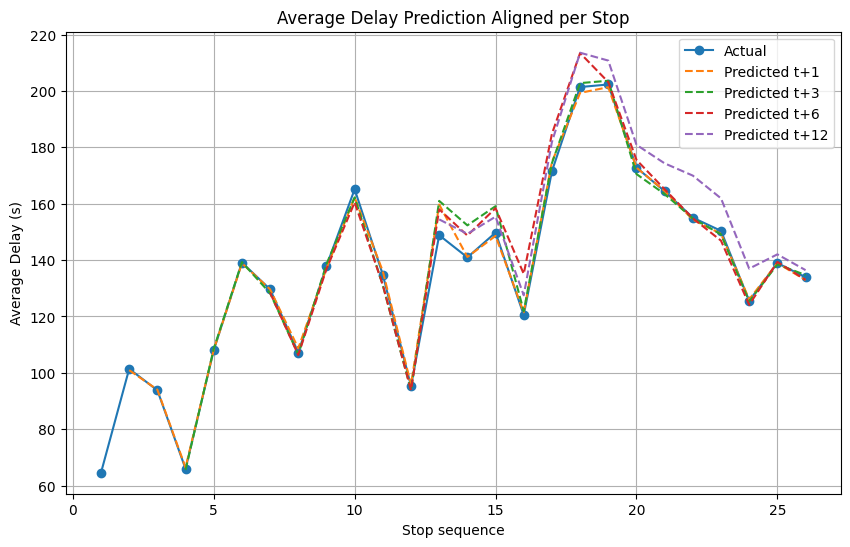

In [33]:
##visa medelvärdet per stopp över alla resor tillsammans med prediction
avg_aligned = pred_df.groupby("stop_sequence")[["arrival_delay"] +
    [f"pred_t+{h}_aligned" for h in [1,3,6,12]]].mean()

plt.figure(figsize=(10,6))
plt.plot(avg_aligned.index, avg_aligned["arrival_delay"], label="Actual", marker='o')
for h in [1,3,6,12]:
    plt.plot(avg_aligned.index, avg_aligned[f"pred_t+{h}_aligned"], '--', label=f"Predicted t+{h}")
plt.xlabel("Stop sequence")
plt.ylabel("Average Delay (s)")
plt.title("Average Delay Prediction Aligned per Stop")
plt.legend()
plt.grid(True)
plt.show()


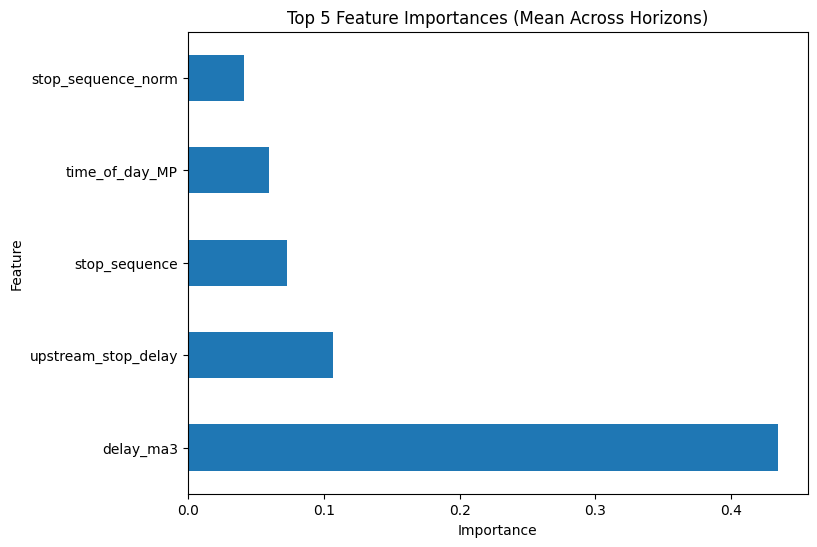

In [48]:
#Feature importance, vilken feature påverkar prediction mest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# samla importances från varje intern modell
importances = []
for i, est in enumerate(xgb_model.estimators_):
    imp = est.feature_importances_
    importances.append(imp)

# medelvärde över alla horisonter
mean_importance = np.mean(importances, axis=0)

# sortera och plotta
feat_imp = pd.Series(mean_importance, index=X.columns).sort_values(ascending=False)
feat_imp.head(5).plot(kind='barh', figsize=(8,6))
plt.title("Top 5 Feature Importances (Mean Across Horizons)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


KNN
- MAE for arrival_delay_t+1: 27.19
- MAE for arrival_delay_t+3: 43.65
- MAE for arrival_delay_t+6: 61.55
- MAE for arrival_delay_t+12: 88.90

single output
- t+1: MAE=18.31, R²=0.978
- t+3: MAE=32.48, R²=0.937
- t+6: MAE=46.89, R²=0.877
- t+12: MAE=70.30, R²=0.747

RF
- MAE for arrival_delay_t+1: 20.42
- MAE for arrival_delay_t+3: 37.31
- MAE for arrival_delay_t+6: 55.17
- MAE for arrival_delay_t+12: 81.35

XGBoost
- arrival_delay_t+1: MAE=19.95, R²=0.922
- arrival_delay_t+3: MAE=36.88, R²=0.878
- arrival_delay_t+6: MAE=54.21, R²=0.820
- arrival_delay_t+12: MAE=80.16, R²=0.725

med multi
- arrival_delay_t+1: MAE=19.37, R²=0.928
- arrival_delay_t+3: MAE=44.72, R²=0.817
- arrival_delay_t+6: MAE=73.83, R²=0.669
- arrival_delay_t+12: MAE=116.72, R²=0.441

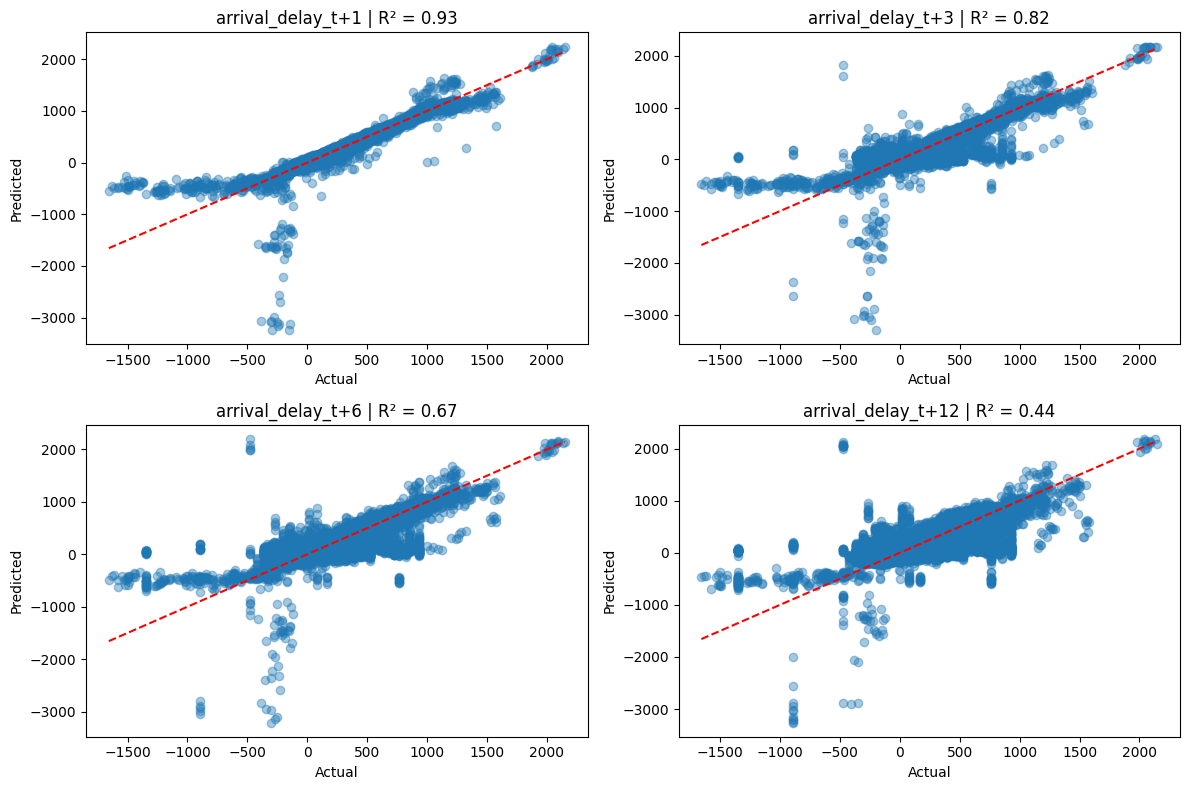

In [47]:
#Korrelation mellan faktisk och predikterad försening per horisont

plt.figure(figsize=(12, 8))
for i, col in enumerate(y.columns):
    plt.subplot(2, 2, i+1)
    plt.scatter(y_test[col], y_pred[:, i], alpha=0.4)
    plt.plot([y_test[col].min(), y_test[col].max()],
             [y_test[col].min(), y_test[col].max()],
             "r--")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{col} | R² = {r2_score(y_test[col], y_pred[:, i]):.2f}")
plt.tight_layout()
plt.show()

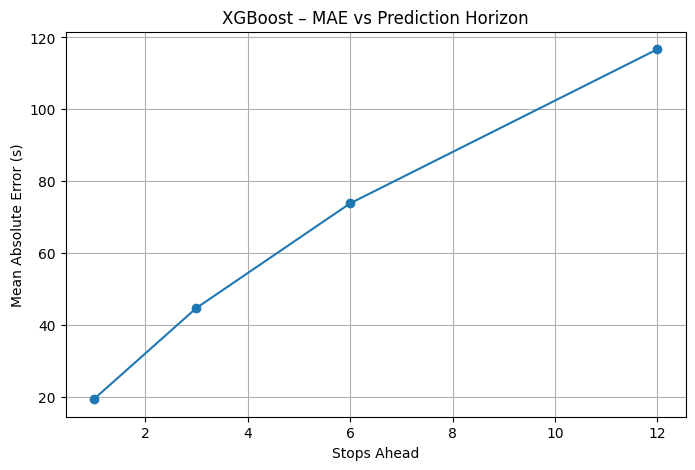

In [38]:
# MAE över prediktionshorisonter: Visar hur prognosprecisionen försämras längre fram i rutten

plt.figure(figsize=(8,5))
plt.plot([1,3,6,12], mae, marker='o', label='MAE')
plt.title("MAE vs Prediction Horizon")
plt.xlabel("Stops Ahead")
plt.ylabel("Mean Absolute Error (s)")
plt.grid(True)
plt.show()


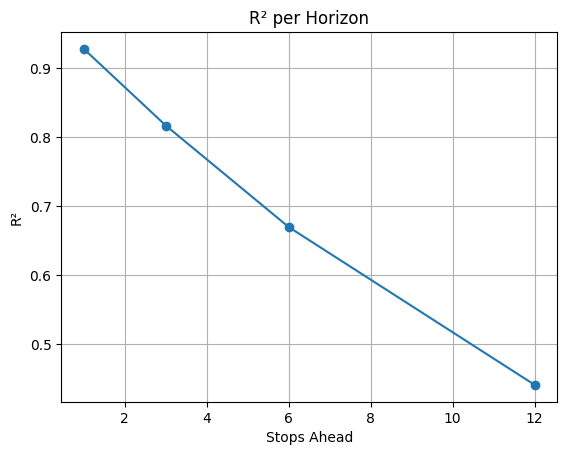

In [46]:
#r2 över prediktionshorisonter: Visar hur prognosprecisionen försämras längre fram i rutten

r2_scores = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y.shape[1])]
plt.plot([1,3,6,12], r2_scores, marker='o')
plt.title("R² per Horizon")
plt.xlabel("Stops Ahead")
plt.ylabel("R²")
plt.grid(True)
plt.show()


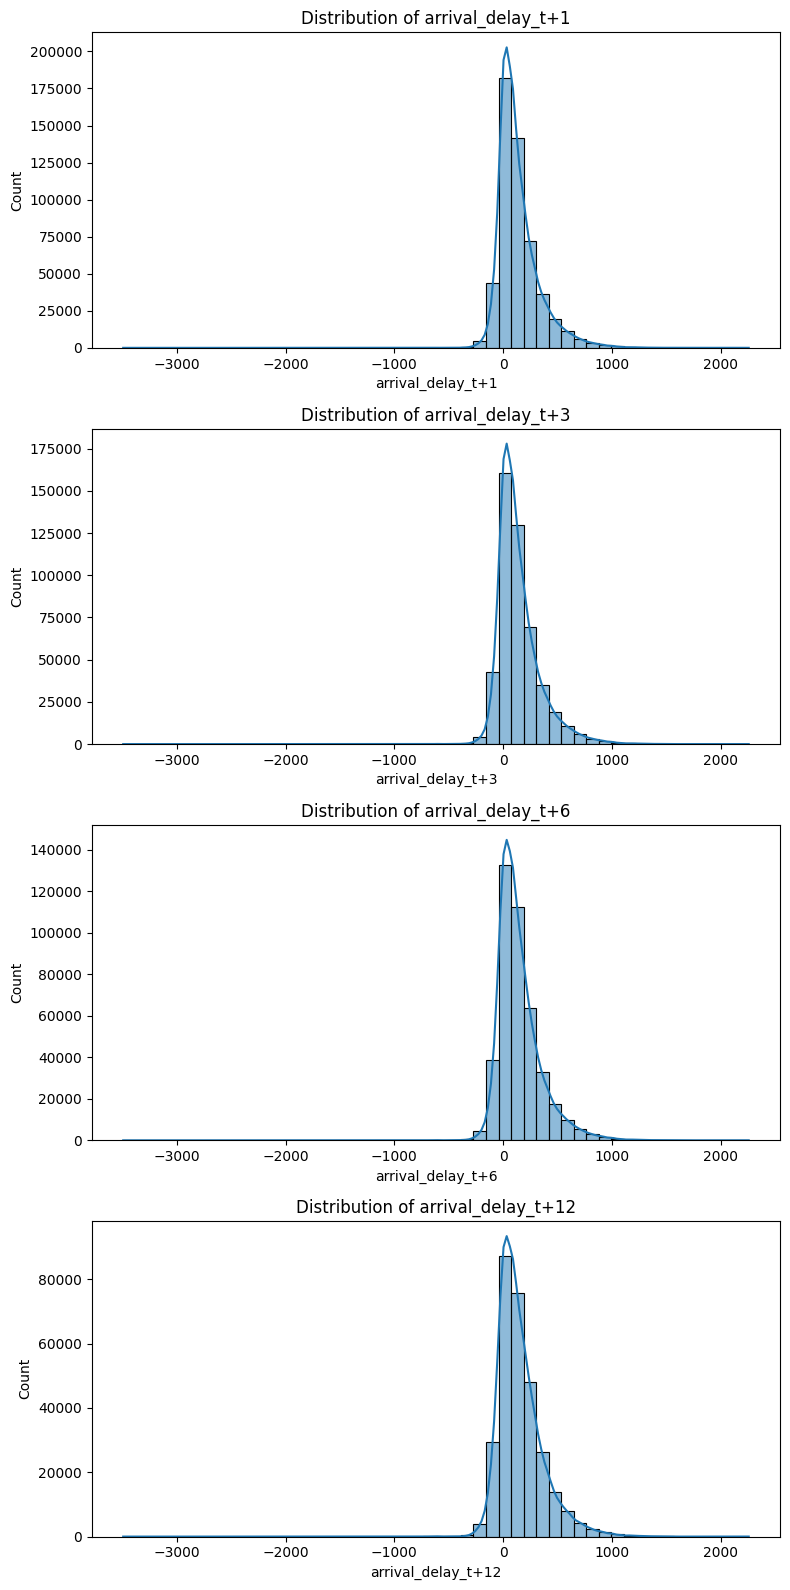

In [45]:
#distributioncheck
fig, axes = plt.subplots(len(targets), 1, figsize=(8, 16))
for i, col in enumerate(targets):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

MAE = the average absolute difference between the models predictions and the actual delay

- MAE for delay_t+1_stop: 34.00
- MAE for delay_t+3_stop: 46.54
- MAE for delay_t+6_stop: 54.66
- MAE for delay_t+12_stop: 56.01

This means that on average, the prediction for the next stop is off by 34 seconds.

Interpretations:
- Errors grow as the horizon length increases, which is expected since uncertainty accumulates further into the future


*olika dummies och deras relation till arrival delay*
- tror inte detta är jätteintressant för min analys

In [ ]:
# skapa en kategori från de one-hot-kodade väderkolumnerna
weather_cols = [c for c in df_vis.columns if "factor(weather)" in c]
df_vis["weather_category"] = df_vis[weather_cols].idxmax(axis=1).str.replace("factor(weather)", "")

sns.boxplot(x="weather_category", y="arrival_delay", data=df_vis)
plt.title("Arrival Delay by Weather Condition")
plt.show()

In [ ]:
tod_cols = [c for c in df_vis.columns if "factor(time_of_day)" in c]
df_vis["time_of_day_category"] = df_vis[tod_cols].idxmax(axis=1).str.replace("factor(time_of_day)", "")

sns.boxplot(x="time_of_day_category", y="arrival_delay", data=df_vis)
plt.title("Arrival Delay by Time of Day")
plt.show()

In [ ]:
dow_cols = [c for c in df_vis.columns if "factor(day_of_week)" in c]
df_vis["day_category"] = df_vis[dow_cols].idxmax(axis=1).str.replace("factor(day_of_week)", "")

sns.boxplot(x="day_category", y="arrival_delay", data=df_vis)
plt.title("Arrival Delay by Weekday/Weekend")
plt.show()